# Imports & Properties / IMF creation

In [1]:
import os
os.environ["PYSYN_CDBS"] = "/Users/joesum/cdbs/grp/redcat/trds"
os.environ['SPISEA_MODELS'] = "/Users/joesum/cdbs/grp/redcat/trds" 
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pdb
import matplotlib.pyplot as plt
from astropy.table import unique
import pickle 
import re

evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
distance = 10  # measured in pc
extinction = 0 # takes extinction in Ks filter in magnitudes
metallicity_bins = [5*i/10 for i in range(-5,2)] # -2.5 and +0.5 are the min and max metalicity values allowed by spisea
age_bins = np.log10([10**i for i in range(6,11)])
mass_bins = [10**i for i in range(6)]
# filter_list = ["wfc3,ir,f127m", "wfc3,ir,f139m", "wfc3,ir,f153m"] # Hubble Filters
filter_list = ["johnson,u", "johnson,b", "johnson,v", "johnson,r","johnson,i"] # Johnson-Cousins
# filter_list = [] #jhk2mass filters
# filter_list = [] #sdss filters 

mass_limits = np.array([1e-2, 1e2])
powers = np.array([-2.35]) # Salpeter function
multiplicity = None
initial_mass_func = imf.IMF_broken_powerlaw(mass_limits, powers, multiplicity)

print(metallicity_bins, len(metallicity_bins))
print(age_bins, len(age_bins))
print(mass_bins, len(mass_bins))

/Users/joesum/opt/anaconda3/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/joesum/cdbs/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5] 7
[ 6.  7.  8.  9. 10.] 5
[1, 10, 100, 1000, 10000, 100000] 6


# Create isochrone and both clusters for all age / metalicity combinations

In [3]:
for metallicity in metallicity_bins:
    for age in age_bins:
        print("iso_a{:.0f}_m{:.0f}".format(age, metallicity*10))
        temp_isochrone = synthetic.IsochronePhot(
            age,
            extinction,
            distance,
            metallicity,
            filters=filter_list,
            evo_model=evo_model,
            atm_func=atm_func,
            red_law=red_law,
        );
        
        temp_file = open("clusters/isochrones/iso_a{:.0f}_m{:.0f}.obj".format(age, metallicity*10), "wb")
        pickle.dump(temp_isochrone, temp_file)



iso_a6_m-25
Changing to logg=5.00 for T= 49691 logg=4.53
Changing to T= 50000 for T= 50137 logg=4.53
Changing to logg=5.00 for T= 50137 logg=4.53
Changing to T= 50000 for T= 50539 logg=4.52
Changing to logg=5.00 for T= 50539 logg=4.52
Changing to T= 50000 for T= 51544 logg=4.52
Changing to logg=5.00 for T= 51544 logg=4.52
Changing to T= 50000 for T= 52254 logg=4.51
Changing to logg=5.00 for T= 52254 logg=4.51
Changing to T= 50000 for T= 53208 logg=4.51
Changing to logg=5.00 for T= 53208 logg=4.51
Changing to T= 50000 for T= 54287 logg=4.50
Changing to logg=5.00 for T= 54287 logg=4.50
Changing to T= 50000 for T= 54799 logg=4.50
Changing to logg=5.00 for T= 54799 logg=4.50
Changing to T= 50000 for T= 55260 logg=4.50
Changing to logg=5.00 for T= 55260 logg=4.50
Changing to T= 50000 for T= 55843 logg=4.49
Changing to logg=5.00 for T= 55843 logg=4.49
Changing to T= 50000 for T= 56328 logg=4.49
Changing to logg=5.00 for T= 56328 logg=4.49
Changing to T= 50000 for T= 56989 logg=4.49
Changing 

Requested metallicity 0.04490434277439099 is out of bounds.


M =   1.033 Msun  T = 83275 K  m_johnson_i = 6.96
      Time taken: 7.47 seconds
iso_a6_m5
Changing to logg=4.50 for T= 39107 logg=4.00
Changing to logg=4.50 for T= 39544 logg=4.00
Changing to logg=4.50 for T= 39986 logg=3.99
Changing to logg=4.50 for T= 40431 logg=3.99
Changing to logg=4.50 for T= 40880 logg=3.98
Changing to logg=4.50 for T= 41331 logg=3.98
Changing to logg=4.50 for T= 41786 logg=3.97
Changing to logg=4.50 for T= 42243 logg=3.97
Changing to logg=4.50 for T= 42701 logg=3.96
Changing to logg=4.50 for T= 43340 logg=3.96
Changing to logg=4.50 for T= 44005 logg=3.96
Changing to logg=4.50 for T= 44589 logg=3.96
Changing to logg=4.50 for T= 45111 logg=3.95
Changing to logg=4.50 for T= 45620 logg=3.95
Changing to logg=4.50 for T= 45580 logg=3.94
Changing to logg=4.50 for T= 47579 logg=3.97
Changing to logg=4.50 for T= 48175 logg=3.98
Changing to logg=4.50 for T= 48996 logg=3.98
Changing to logg=5.00 for T= 49323 logg=3.98
Changing to T= 50000 for T= 50490 logg=3.99
Changing t

Requested metallicity 0.04490434277439099 is out of bounds.


M =   8.109 Msun  T = 20805 K  m_johnson_i = -1.60
      Time taken: 1.51 seconds
iso_a7_m5
Changing to logg=3.00 for T= 19350 logg=2.98
Changing to logg=3.00 for T= 19070 logg=2.95
Changing to logg=2.50 for T= 14616 logg=2.48
Changing to logg=2.50 for T= 14400 logg=2.45
Changing to logg=2.50 for T= 14186 logg=2.43
Changing to logg=2.50 for T= 13976 logg=2.40
Changing to logg=2.50 for T= 13768 logg=2.38
Changing to logg=2.50 for T= 13564 logg=2.35
Changing to logg=2.50 for T= 13362 logg=2.33
Changing to logg=2.50 for T= 13164 logg=2.30
Changing to logg=2.50 for T= 12968 logg=2.28
Changing to logg=2.50 for T= 12775 logg=2.26
Changing to logg=2.50 for T= 12585 logg=2.23
Changing to logg=2.50 for T= 12398 logg=2.21
Changing to logg=2.50 for T= 12213 logg=2.18
Changing to logg=2.50 for T= 12031 logg=2.16
Changing to logg=2.50 for T= 11852 logg=2.13
Changing to logg=2.00 for T= 10829 logg=1.99
Changing to logg=2.00 for T= 10667 logg=1.96
Changing to logg=2.00 for T= 10508 logg=1.94
Changing

Requested metallicity 0.04490434277439099 is out of bounds.


iso_a8_m5
Isochrone generation took 29.845409 s.
Making photometry for isochrone: log(t) = 8.00  AKs = 0.00  dist = 10
     Starting at:  2022-03-16 13:26:22.329960   Usually takes ~5 minutes
Starting filter: johnson,u   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.139 Msun  T =  2448 K  m_johnson_u = 18.32
M =   1.301 Msun  T =  6029 K  m_johnson_u = 5.02
M =   4.030 Msun  T = 12097 K  m_johnson_u = -1.14
M =   5.048 Msun  T = 12306 K  m_johnson_u = -2.79
M =   5.058 Msun  T =  4935 K  m_johnson_u = 0.36
M =   5.086 Msun  T =  3930 K  m_johnson_u = 2.00
M =   5.337 Msun  T =  3631 K  m_johnson_u = 1.86
M =   5.348 Msun  T = 16363 K  m_johnson_u = -5.95
M =   5.348 Msun  T = 239713 K  m_johnson_u = 1.44
M =   5.355 Msun  T = 87025 K  m_johnson_u = 6.98
Starting filter: johnson,b   Elapsed time: 1.34 seconds
Starting synthetic photometry
M =   0.139 Msun  T =  2448 K  m_johnson_b = 17.27
M =   1.301 Msun  T =  6029 K  m_johnson_b = 4.81
M =   4.030 Msun  T = 12097 K 

Requested metallicity 0.04490434277439099 is out of bounds.


iso_a9_m5
Isochrone generation took 40.711783 s.
Making photometry for isochrone: log(t) = 9.00  AKs = 0.00  dist = 10
     Starting at:  2022-03-16 13:27:10.246667   Usually takes ~5 minutes
Starting filter: johnson,u   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.151 Msun  T =  2472 K  m_johnson_u = 19.55
M =   0.945 Msun  T =  5007 K  m_johnson_u = 7.84
M =   2.160 Msun  T =  6307 K  m_johnson_u = 2.10
M =   2.223 Msun  T =  5287 K  m_johnson_u = 3.03
M =   2.234 Msun  T =  4124 K  m_johnson_u = 3.57
M =   2.418 Msun  T =  4509 K  m_johnson_u = 3.36
M =   2.433 Msun  T =  3635 K  m_johnson_u = 3.13
M =   2.434 Msun  T =  3044 K  m_johnson_u = 3.15
M =   2.434 Msun  T =  3097 K  m_johnson_u = 3.15
M =   2.434 Msun  T =  2994 K  m_johnson_u = 3.34
M =   2.435 Msun  T = 63904 K  m_johnson_u = -1.47
M =   2.435 Msun  T = 134439 K  m_johnson_u = 3.78
Starting filter: johnson,b   Elapsed time: 1.61 seconds
Starting synthetic photometry
M =   0.151 Msun  T =  2472 K  m_

Requested metallicity 0.04490434277439099 is out of bounds.


      Time taken: 8.46 seconds
iso_a10_m5
Changing to T=  2300 for T=  2259 logg=5.08
Changing to T=  2300 for T=  2284 logg=5.07
Isochrone generation took 31.149793 s.
Making photometry for isochrone: log(t) = 10.00  AKs = 0.00  dist = 10
     Starting at:  2022-03-16 13:27:50.027486   Usually takes ~5 minutes
Starting filter: johnson,u   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.109 Msun  T =  2259 K  m_johnson_u = 21.69
M =   0.802 Msun  T =  4557 K  m_johnson_u = 9.15
M =   1.069 Msun  T =  5404 K  m_johnson_u = 5.68
M =   1.116 Msun  T =  3790 K  m_johnson_u = 4.50
M =   1.117 Msun  T =  4282 K  m_johnson_u = 4.52
M =   1.122 Msun  T =  3711 K  m_johnson_u = 4.24
M =   1.122 Msun  T =  2956 K  m_johnson_u = 4.33
M =   1.122 Msun  T = 44217 K  m_johnson_u = -1.80
M =   1.122 Msun  T = 91516 K  m_johnson_u = 2.10
Starting filter: johnson,b   Elapsed time: 1.34 seconds
Starting synthetic photometry
M =   0.109 Msun  T =  2259 K  m_johnson_b = 19.40
M =   0.802 

In [2]:
mass = 10_000
seed = None

for file_name in os.listdir("clusters/isochrones"):
    nums = [int(i) for i in re.findall('[0-9]+', file_name)]
    age, met = nums[0], nums[1]
    iso = pickle.load(open("clusters/isochrones/{}".format(file_name), "rb"))
        
    unresolved = synthetic.UnresolvedCluster(
    iso, initial_mass_func, mass, [3000, 52000], verbose=False)
    temp_file = open("clusters/unresolved/uc_a{:.0f}_m{:.0f}.obj".format(age, met*10), "wb")
    pickle.dump(unresolved, temp_file)

    resolved = synthetic.ResolvedCluster(
    iso, initial_mass_func, mass, seed=seed)
    temp_file = open("clusters/resolved/rc_a{:.0f}_m{:.0f}.obj".format(age, met*10), "wb")
    pickle.dump(resolved, temp_file)
  

# Generate Unresolved Clusters for age = 1 / Gyr M/H = 0 with varying mass

In [3]:
iso = pickle.load(open("clusters/isochrones/iso_a9_m0.obj", "rb"))
mass_limits = np.array([1e-2, 1e2])
powers = np.array([-2.35]) # Salpeter function
multiplicity = None
initial_mass_func = imf.IMF_broken_powerlaw(mass_limits, powers, multiplicity)

print(iso.points.keys())

for mass in mass_bins:
    temp_unres_clust = synthetic.UnresolvedCluster(
        iso, initial_mass_func, mass, [100, 7500], verbose=False)
    temp_file = open("clusters/mass-dependance/mass{:.0f}.obj".format(np.log10(mass)),"wb")
    pickle.dump(temp_unres_clust, temp_file)


['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']
Mass matching took 0.002760 s.
Spec summing took 0.000096s
Spec trimming took 0.000272s
Total cluster mass is 0.250817 M_sun
Mass matching took 0.017531 s.
Spec summing took 0.000320s
Spec trimming took 0.000196s
Total cluster mass is 3.262590 M_sun
Mass matching took 0.299070 s.
Spec summing took 0.001252s
Spec trimming took 0.000320s
Total cluster mass is 27.479839 M_sun
Mass matching took 2.099990 s.
Spec summing took 0.033090s
Spec trimming took 0.000536s
Total cluster mass is 304.049454 M_sun
Mass matching took 21.607362 s.
Spec summing took 1.654154s
Spec trimming took 0.022594s
Total cluster mass is 3173.716024 M_sun
Mass matching took 214.303860 s.
Spec summing took 52.158200s
Spec trimming took 2.324923s
Total cluster mass is 31475.506491 M_sun


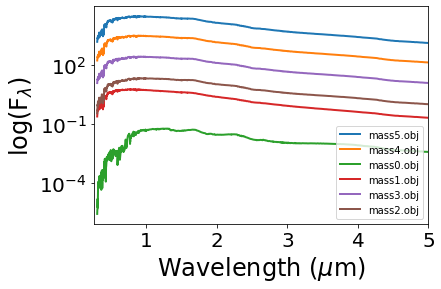

In [17]:
for file_name in os.listdir("clusters/mass-dependance"):
        unresolved_cluster = pickle.load(open("clusters/mass-dependance/{}".format(file_name), "rb"))
        plt.plot(unresolved_cluster.wave_trim*10**-4,
                unresolved_cluster.spec_trim,#*unresolved_cluster.wave_trim,
                label=file_name, linewidth=2)
        plt.xlabel('Wavelength ($\mu$m)', fontsize=24)
        plt.ylabel('log(F$_{\lambda}$)', fontsize=24) #'log($\lambda$F$_{\lambda}$)'
        plt.tick_params(axis='both', labelsize=20)
        plt.legend()
        plt.xlim(0.25,5.0)
        plt.gca().set_yscale('log')
        plt.rcParams["figure.figsize"] = (9,9)

plt.show()